# Color Space Conversion

This example showcases different color space conversion operations available in DALI.

## Defining the Pipeline

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types


image_dir = "../data/images"

conversions = [
    ("RGB to BGR", types.RGB, types.BGR),
    ("RGB to YCbCR", types.RGB, types.YCbCr),
    ("RGB to Gray", types.RGB, types.GRAY),
]


@pipeline_def()
def conversion_pipeline():
    files, labels = fn.readers.file(file_root=image_dir)
    images_cpu = fn.decoders.image(files)
    images_gpu = images_cpu.gpu()
    converted_cpu = [
        fn.color_space_conversion(
            images_cpu, image_type=inp_t, output_type=out_t
        )
        for _, inp_t, out_t in conversions
    ]
    converted_gpu = [
        fn.color_space_conversion(
            images_gpu, image_type=inp_t, output_type=out_t
        )
        for _, inp_t, out_t in conversions
    ]
    return tuple([images_cpu] + converted_cpu + converted_gpu)

## Building and Running the Pipeline

In [2]:
batch_size = 32

pipe = conversion_pipeline(batch_size=batch_size, num_threads=2, device_id=0)
pipe.build()
pipe_out = pipe.run()

## Visualizing the Results

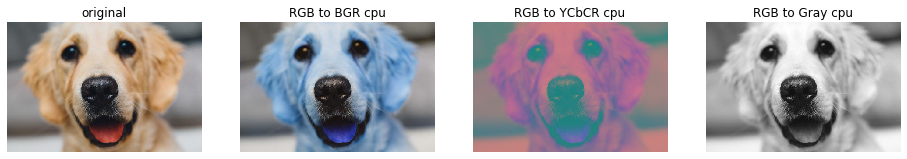

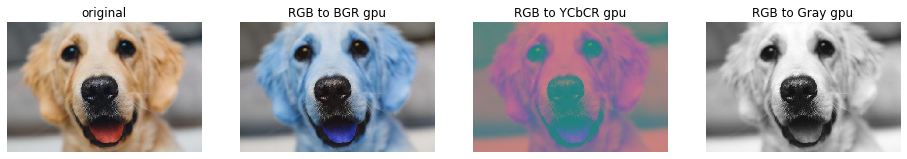

In [3]:
import matplotlib.pyplot as plt
import math
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec

n = 1
len_outputs = len(pipe_out)
original_images = pipe_out[0]
n_conversions = len(conversions)

conversions_cpu = [elem for elem in pipe_out[1 : n_conversions + 1]]
conversions_gpu = [elem for elem in pipe_out[n_conversions + 1 :]]

titles = [title for title, _, _ in conversions]


def show_images(original, conversions, titles_conversions, device):
    outputs = conversions
    titles = [elem + " " + device for elem in titles_conversions]
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    rows = 1 + int(math.ceil(1.0 * len_outputs / columns))
    gs = gridspec.GridSpec(rows, columns)

    plt.subplot(gs[0])
    plt.axis("off")
    plt.title("original")
    plt.imshow(original.at(n))

    for i in range(len(conversions)):
        plt.subplot(gs[i + 1])
        plt.axis("off")
        plt.title(titles[i])
        img_chw = (
            outputs[i].as_cpu().at(n) if device == "gpu" else outputs[i].at(n)
        )
        shape = img_chw.shape
        if shape[2] == 1:
            plt.imshow(img_chw.reshape(shape[0], shape[1]), cmap="gray")
        else:
            plt.imshow(img_chw)


show_images(
    original=original_images,
    conversions=conversions_cpu,
    titles_conversions=titles,
    device="cpu",
)
show_images(
    original=original_images,
    conversions=conversions_gpu,
    titles_conversions=titles,
    device="gpu",
)